In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, datetime
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import geopandas as gpd
import geojson
import shapely
import shapely.geometry

In [3]:
import matplotlib.pyplot as plt
import contextily

In [4]:
from src import *

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = read_data('data/train_dataset_train_2.csv')
data_test = read_data('data/test_dataset_test_2.csv')
data_ts, data_id = process_data(data)
data_ts_test, data_id_test = process_data(data_test)

In [7]:
# data = data_ts.copy()
# data['geometry'] = data_id['geometry']
# data = gpd.GeoDataFrame(data)

In [8]:
# data_test = data_ts_test.copy()
# data_test['geometry'] = data_id_test['geometry']
# data_test = gpd.GeoDataFrame(data_test)

# plotting

In [ ]:
# grid from:
# http://book.ecosens.org/modis-sinusoidal-grid-download/
# crs from:
# https://spatialreference.org/ref/sr-org/modis-sinusoidal-3/ogcwkt/

In [88]:
modis_grid = gpd.read_file('modis_grid/modis_sinusoidal_grid_world.shp')
with open('modis_grid/modis_sinusoidal_grid_world.prj') as f:
    modis_crs = f.read()

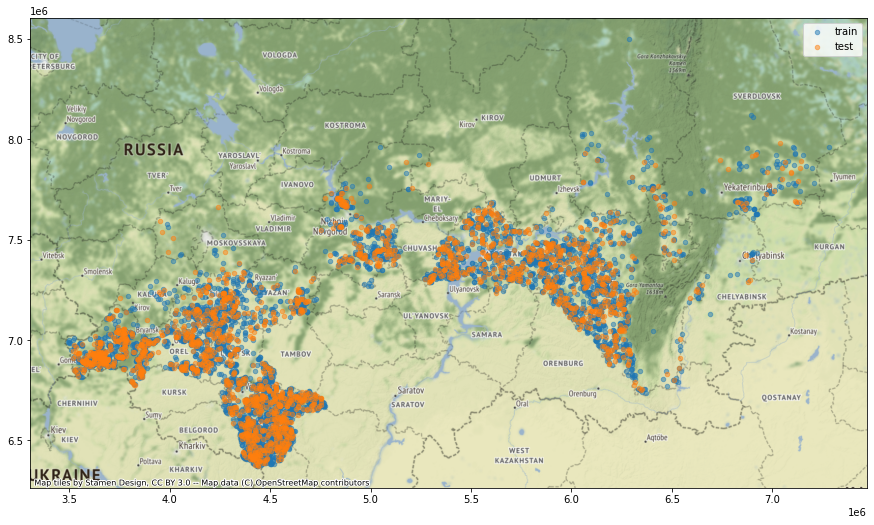

In [108]:
base = data.to_crs(epsg=3857).geometry.centroid.plot(figsize=(15,15), alpha=0.5, linewidth=1, markersize=20)
data_test.to_crs(3857).geometry.centroid.plot(ax=base, alpha=0.5, linewidth=1, markersize=20)
plt.legend(('train', 'test'))
contextily.add_basemap(base)

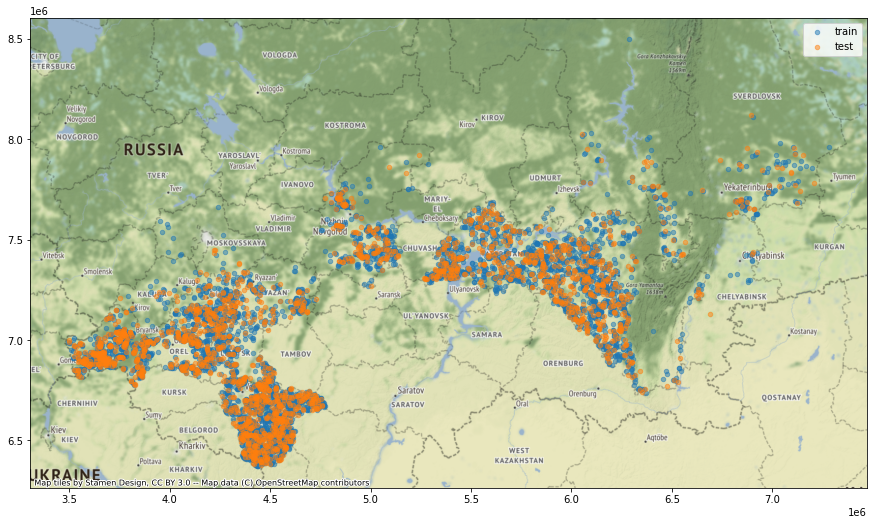

In [107]:
base = data_2.to_crs(epsg=3857).geometry.centroid.plot(figsize=(15,15), alpha=0.5, linewidth=1, markersize=20)
data_test_2.to_crs(3857).geometry.centroid.plot(ax=base, alpha=0.5, linewidth=1, markersize=20)
plt.legend(('train', 'test'))
contextily.add_basemap(base)

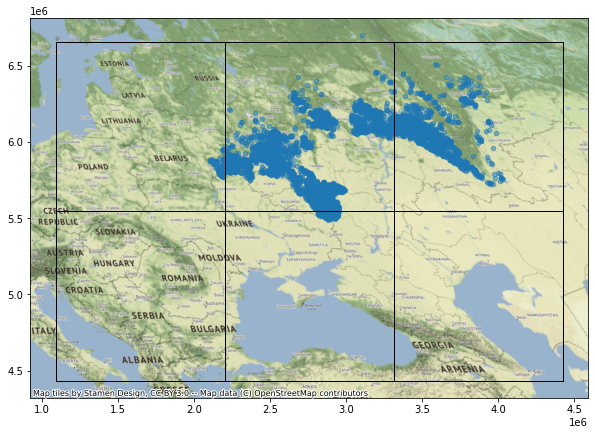

In [91]:
ax = data.geometry.to_crs(modis_crs).centroid.plot(figsize=(10,10), alpha=0.5, linewidth=1, markersize=20)
modis_grid[modis_grid['v'].isin([3,4]) & modis_grid['h'].isin([19,20,21])] \
.to_crs(modis_crs).plot(ax=ax, edgecolor="black", facecolor="none")
contextily.add_basemap(ax, crs=modis_crs)

In [40]:
data_ts, data_id = process_data(data)
data_ts_test, data_id_test = process_data(data_test)

In [26]:
# data_ts = data_ts.replace(0.0, None)
# data_ts = data_ts.T.ffill().T

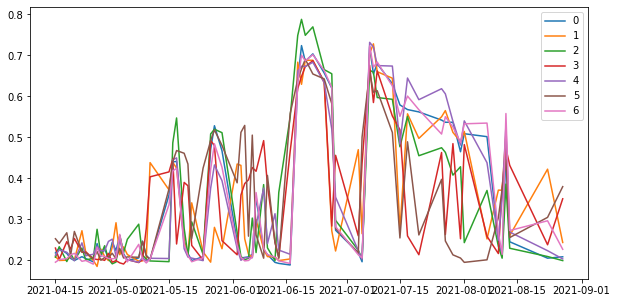

In [27]:
plt.figure(figsize=(10,5))
plot_data = data_ts.groupby(data_id['crop']).mean().T
plt.plot(plot_data);
plt.legend(plot_data.columns)

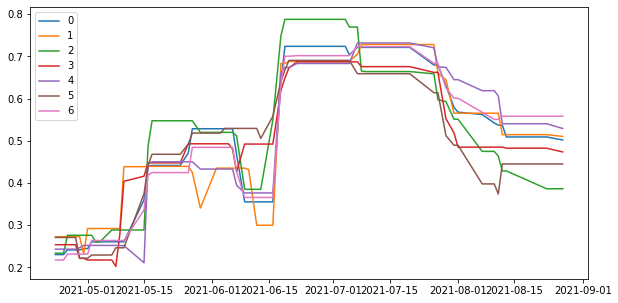

In [28]:
plt.figure(figsize=(10,5))
plot_data = data_ts.groupby(data_id['crop']).mean().T.rolling(7).max()
plt.plot(plot_data);
plt.legend(plot_data.columns)

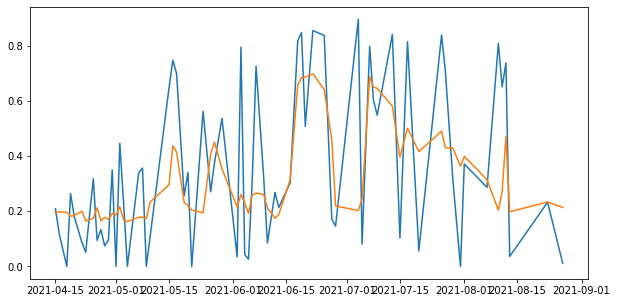

In [39]:
plt.figure(figsize=(10,5))
plt.plot(data_ts_test.iloc[5,:])
plt.plot(data_ts_test.mean())

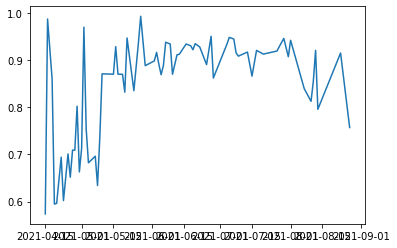

In [61]:
plt.plot(data_ts_test.max())

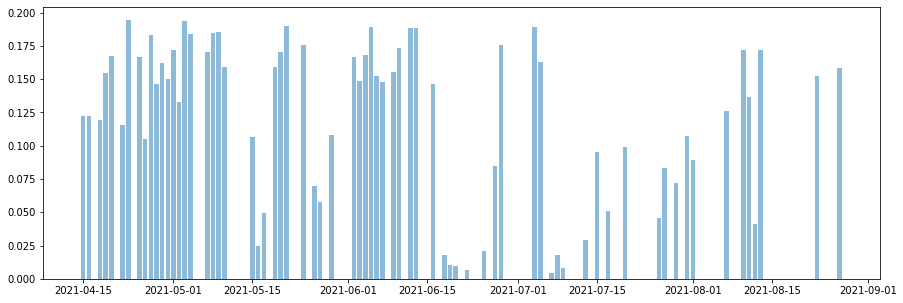

In [64]:
plt.figure(figsize=(15,5))
# plt.plot(data_ts.mean());
plt.bar(x=data_ts.columns, height=data_ts.eq(0.0).mean(), alpha=0.5);

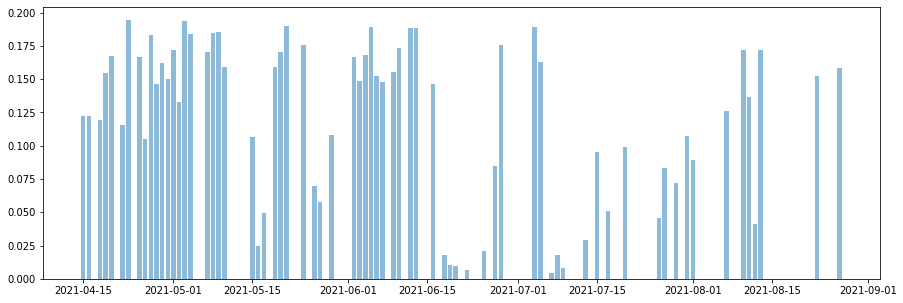

In [60]:
plt.figure(figsize=(15,5))
plt.bar(x=data_ts_test.columns, height=data_ts.eq(0.0).mean(), alpha=0.5);

# clustering

In [9]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans

In [81]:
data_0 = data_ts.loc[data_id['crop'].eq(0)]

In [99]:
metrics = []
for n in range(2, 10):
    alg = KMeans(n_clusters=n, random_state=37864)
    alg.fit(data_ts.values)
    classes = alg.predict(data_ts.values)
    j = alg.inertia_
    ch = calinski_harabasz_score(data_ts.values, classes)
    s = silhouette_score(data_ts.values, classes)
    metrics.append({'J': j, 'calinski_harabasz_score': ch, 'silhouette_score': s})
metrics = pd.DataFrame(metrics, index=range(2,10))

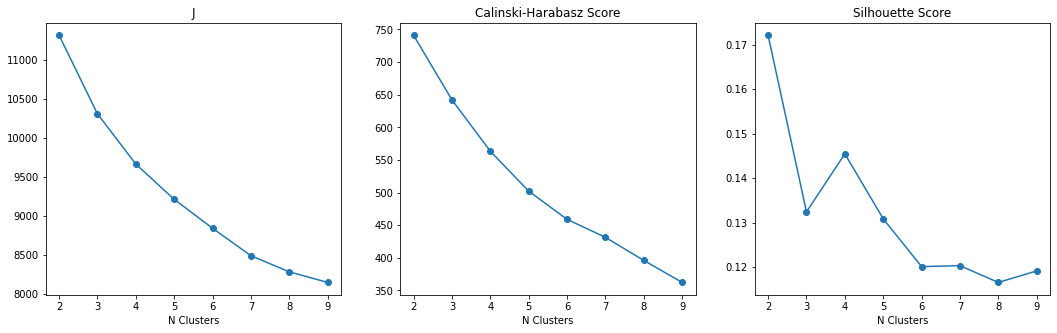

In [100]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].plot(metrics['J'], 'o-')
ax[0].set_title('J');
ax[0].set_xlabel('N Clusters');
ax[1].plot(metrics['calinski_harabasz_score'], 'o-')
ax[1].set_title('Calinski-Harabasz Score');
ax[1].set_xlabel('N Clusters');
ax[2].plot(metrics['silhouette_score'], 'o-')
ax[2].set_title('Silhouette Score');
ax[2].set_xlabel('N Clusters');

In [10]:
alg = KMeans(n_clusters=2, random_state=37864)
clusters = alg.fit_predict(data_ts.values)

In [11]:
data_ts_modis = pd.read_csv('data/train_dataset_modis.csv').fillna(0.0)
data_ts_modis_test = pd.read_csv('data/test_dataset_modis.csv').fillna(0.0)
data_ts_modis_2020 = pd.read_csv('data/train_dataset_modis_2020.csv').fillna(0.0)
data_ts_modis_test_2020 = pd.read_csv('data/test_dataset_modis_2020.csv').fillna(0.0)

In [116]:
data_ts_modis.iloc[clusters.astype(bool)]

,2021/04/15,2021/04/16,2021/04/17,2021/04/18,2021/04/19,2021/04/20,2021/04/21,2021/04/22,2021/04/23,2021/04/24,...,2021/08/22,2021/08/23,2021/08/24,2021/08/25,2021/08/26,2021/08/27,2021/08/28,2021/08/29,2021/08/30,2021/08/31
0,0.183781,0.226578,0.004179,0.268499,0.285949,-0.002850,0.004609,0.248011,0.008315,0.009573,...,0.508478,0.059735,0.639200,0.670145,0.697095,0.644649,0.648744,0.608651,0.598301,0.610313
1,0.240117,0.333333,0.281874,0.301619,0.282097,0.322779,0.037727,0.006506,0.224592,0.016086,...,0.038164,0.542737,0.158127,0.506930,0.560636,0.028058,0.442249,0.454817,0.407195,0.006151
2,0.169372,0.007104,0.067649,0.016033,0.008515,0.002977,0.012452,0.156111,0.269231,0.003464,...,0.011416,0.659389,0.097766,-0.001806,0.009511,0.118182,0.196690,0.354147,0.378602,0.318474
4,0.095790,0.020661,0.005525,0.149839,0.021870,0.005109,0.018407,0.243234,-0.001776,0.035522,...,0.416137,0.751992,0.153107,0.010728,0.441834,0.009304,0.504661,0.407637,0.727681,-0.004496
6,0.078844,0.008400,0.009370,0.159067,0.162637,0.018054,0.077433,0.366194,0.017753,0.525596,...,0.566355,0.661890,0.019956,0.013238,0.016827,0.010229,0.031564,0.572402,0.065221,0.002802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4824,0.095855,0.008353,0.033362,0.302126,0.013850,0.106608,0.013793,0.383932,0.237063,0.032919,...,0.057641,0.356595,0.329335,0.007880,0.010837,0.004244,0.095633,0.424465,0.441035,0.369072
4825,0.023978,0.259067,-0.003073,0.023881,0.020884,0.013381,0.012812,0.248179,0.290323,-0.000418,...,0.375905,0.035199,0.741797,0.732026,0.688516,-0.000386,0.696558,0.435799,0.690958,0.669687
4826,0.213740,0.072795,0.008432,0.020107,0.024914,0.006078,0.007188,0.038712,0.023363,0.001636,...,0.903608,0.215810,0.407435,0.785430,0.163708,0.009445,0.046147,0.581749,0.745380,0.729016
4827,0.043221,0.354839,-0.003700,0.065768,0.032542,0.009480,0.014539,0.095579,0.043802,0.008968,...,0.027391,0.619242,0.280299,0.012873,0.001470,0.002594,0.496511,0.732350,0.696689,0.706675


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

In [12]:
data_id['cluster'] = clusters.astype(bool)

In [13]:
SEED = 2

dataset_orig = get_dataset(data_ts, data_id, data_ts_test, data_id_test, random_state=SEED)

dataset_modis = get_dataset(data_ts_modis, data_id, data_ts_modis_test, data_id_test, random_state=SEED)
dataset_modis_2020 = get_dataset(data_ts_modis_2020, data_id, data_ts_modis_test_2020, data_id_test, random_state=SEED)

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=1, verbose=False)
rf.fit(**dataset_orig['train'])
preds = rf.predict(dataset_orig['val']['X'])
recall_score(preds, dataset_orig['val']['y'], average='macro')

0.9637525504321613

In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=1, verbose=False)
rf.fit(**dataset_modis['train'])
preds = rf.predict(dataset_modis['val']['X'])
recall_score(preds, dataset_modis['val']['y'], average='macro')

0.5733636504397959

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=1, verbose=False)
rf.fit(**dataset_modis_2020['train'])
preds = rf.predict(dataset_modis_2020['val']['X'])
recall_score(preds, dataset_modis_2020['val']['y'], average='macro')

0.5313612803528

In [22]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(data_id, test_size=0.2, random_state=1)

In [44]:
rf = RandomForestClassifier(n_estimators=100, random_state=1, verbose=False)
rf.fit(dataset_modis_2020['train']['X'][train['cluster'].values], dataset_modis_2020['train']['y'][train['cluster'].values])
preds = rf.predict(dataset_modis_2020['val']['X'][val['cluster'].values])
recall_score(preds, dataset_modis_2020['val']['y'][val['cluster'].values], average='macro')

0.5006729463538809